# Ordinal analysis of the MTurk Experiment

In [1]:
# %load std_ipython_import.txt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import pymc3 as pm
import theano.tensor as tt

from theano.compile.ops import as_op
from scipy.stats import norm
from matplotlib import gridspec
from matplotlib.patches import Rectangle
from IPython.display import Image

%matplotlib inline
plt.style.use('seaborn-white')

color = '#87ceeb'

f_dict = {'size':14}

# Data

In [2]:
# Using dtype 'category' for Y
df = pd.read_csv(
    'data/all_item_output.csv',
    dtype={
        'y': 'int',
        'gesture': 'int',
        'dist': 'int',
        'shading': 'int'
    })
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 633 entries, 0 to 632
Data columns (total 5 columns):
gesture    633 non-null int64
dist       633 non-null int64
shading    633 non-null int64
y          633 non-null int64
cond       633 non-null int64
dtypes: int64(5)
memory usage: 24.8 KB


In [3]:
df['y'] = (df['y'] + 4).astype('category') # changing the range to 1-7
dfpos = df[df.cond==1]
dfneg = df[df.cond==0]

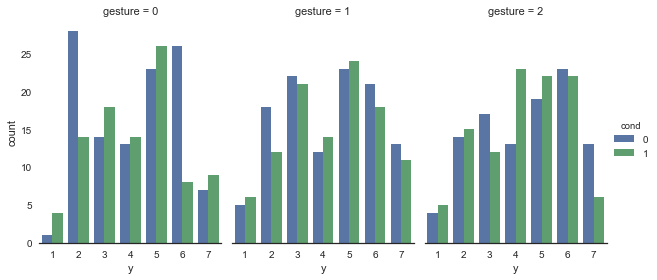

In [4]:
g = sb.factorplot(x="y", hue="cond", col="gesture", data=df, kind="count", size=4, aspect=0.7)
g.despine(left=True)
g.savefig("condition-gesture-counts.pdf")

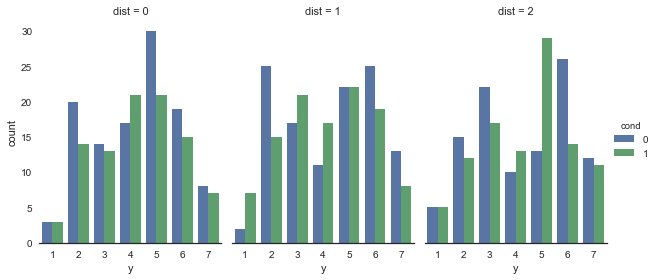

In [5]:
g = sb.factorplot(x="y", hue="cond", col="dist", data=df, kind="count", size=4, aspect=0.7)
g.despine(left=True)
g.savefig("condition-dist-counts.pdf")

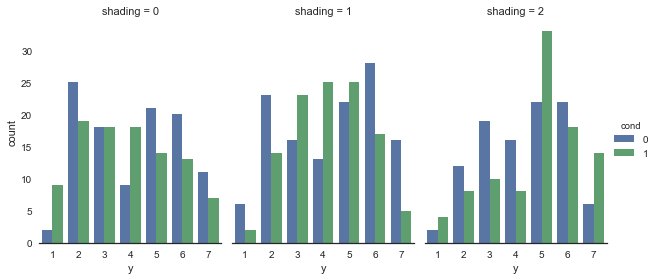

In [6]:
g = sb.factorplot(x="y", hue="cond", col="shading", data=df, kind="count", size=4, aspect=0.7)
g.despine(left=True)
g.savefig("condition-shading-counts.pdf")

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 633 entries, 0 to 632
Data columns (total 5 columns):
gesture    633 non-null int64
dist       633 non-null int64
shading    633 non-null int64
y          633 non-null category
cond       633 non-null int64
dtypes: category(1), int64(4)
memory usage: 20.5 KB


In [8]:
X = df[['gesture','dist', 'shading']]
y_cat = df['y'] # in range 1-7
nYlevels = y_cat.cat.categories.size

In [9]:
# sd_X = X.std()
# mean_X = X.mean()
# zX = (X - mean_X)/sd_X
zX = X # don't normalize because all values are between 0-2

In [10]:
nYlevels4 = y_cat.nunique()

thresh4 = [k + 0.5
           for k in range(1, nYlevels4)]  # fixing the boundaries in our case
thresh_obs4 = np.ma.asarray(thresh4)
thresh_obs4[1:-1] = np.ma.masked

print('thresh4:\t{}'.format(thresh4))
print('thresh_obs4:\t{}'.format(thresh_obs4))

thresh4:	[1.5, 2.5, 3.5, 4.5, 5.5, 6.5]
thresh_obs4:	[1.5 -- -- -- -- 6.5]


In [11]:
@as_op(itypes=[tt.dvector, tt.dvector, tt.dscalar], otypes=[tt.dmatrix])
def outcome_probabilities(theta, mu, sigma):
    out = np.empty((mu.size, nYlevels4))
    n = norm(loc=mu, scale=sigma)       
    out[:,0] = n.cdf(theta[0])        
    out[:,1] = np.max([np.repeat(0,mu.size), n.cdf(theta[1]) - n.cdf(theta[0])], axis=0)
    out[:,2] = np.max([np.repeat(0,mu.size), n.cdf(theta[2]) - n.cdf(theta[1])], axis=0)
    out[:,3] = np.max([np.repeat(0,mu.size), n.cdf(theta[3]) - n.cdf(theta[2])], axis=0)
    out[:,4] = np.max([np.repeat(0,mu.size), n.cdf(theta[4]) - n.cdf(theta[3])], axis=0)
    out[:,5] = np.max([np.repeat(0,mu.size), n.cdf(theta[5]) - n.cdf(theta[4])], axis=0)
    out[:,6] = 1 - n.cdf(theta[5])
    return out



with pm.Model() as ordinal_model_multi_metric:

    theta = pm.Normal(
        'theta',
        mu=thresh4,
        tau=np.repeat(1 / 2**2, len(thresh4)),
        shape=len(thresh4),
        observed=thresh_obs4,
        testval=thresh4[1:-1])

    # all coefficients should center at 0.0 because outocme 'y' is symmetric [-3,3]
    zbeta0 = pm.Normal('zbeta0', mu=(1 + nYlevels4)/2, tau=1 / nYlevels4**2)
    zbeta = pm.Normal('zbeta', mu=0.0, tau=1 / nYlevels4**2, shape=X.shape[1])
    mu = pm.Deterministic('mu', zbeta0 + pm.math.dot(zbeta, zX.T))
    zsigma = pm.Uniform('zsigma', nYlevels4/1000.0, nYlevels4*10.0)

    pr = outcome_probabilities(theta, mu, zsigma)
    
    y = pm.Categorical('y', pr, observed=y_cat.cat.codes)

In [12]:
with ordinal_model_multi_metric:
    step1 = pm.Metropolis(vars=[pr, y, zbeta0, zbeta, zsigma])
    trace4 = pm.sample(10000, step=step1)

100%|██████████| 10000/10000 [05:12<00:00, 32.04it/s]


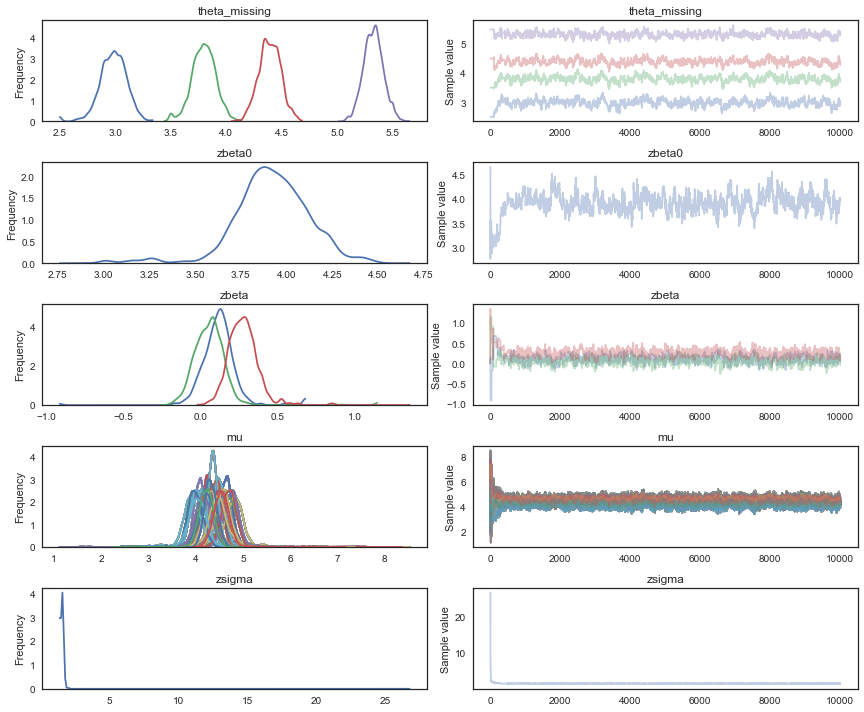

In [13]:
pm.traceplot(trace4);

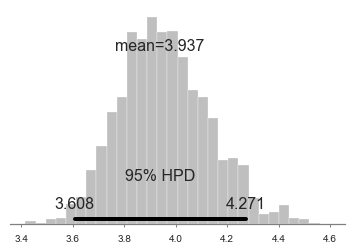

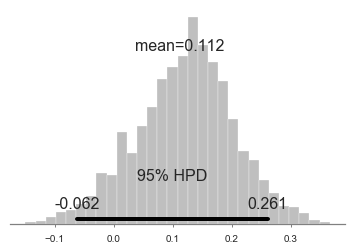

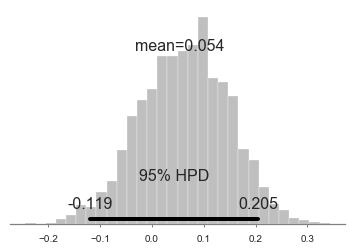

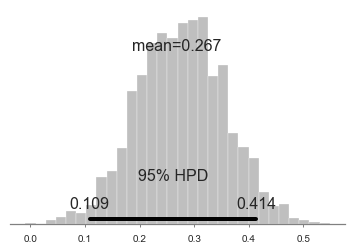

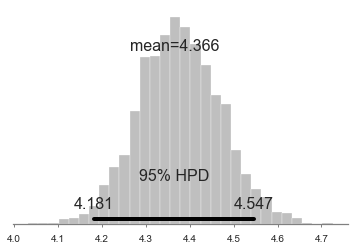

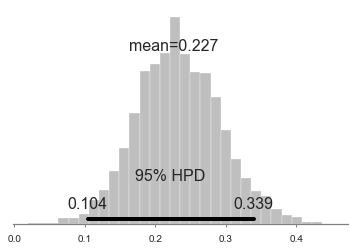

In [27]:
burnin = 400
# Convert parameters to original scale
beta = trace4['zbeta'][burnin:]
beta0 = trace4['zbeta0'][burnin:]
sigma = trace4['zsigma'][burnin:]
mu = trace4['mu'][burnin:]
mu_mean = np.mean(mu, axis=1)

center = 4
n_m = (mu_mean - center)/sigma

# Plot posteriors    
pm.plot_posterior(beta0, point_estimate='mean', color='0.75')
pm.plot_posterior(beta[:,0], point_estimate='mean', color='0.75')
pm.plot_posterior(beta[:,1], point_estimate='mean', color='0.75')
pm.plot_posterior(beta[:,2], point_estimate='mean', color='0.75')
pm.plot_posterior(mu_mean, point_estimate='mean', color='0.75')
pm.plot_posterior(n_m, point_estimate='mean', color='0.75')


# for title, label, ax in zip(['Intercept', 'Year', 'Length'],
#                             [r'$\beta_{0}$', r'$\beta_{1}$', r'$\beta_{2}$'],
#                             [ax2, ax3, ax4]):
#     ax.set_title(title, fontdict=f_dict)
#     ax.set_xlabel(label, fontdict=f_dict)

In [26]:
mu_mean = np.mean(mu, axis=1)
c = 4

n_m = (mu_mean - c)/sigma
n_m.shape

(9600,)

#### Figure 23.9
Equation 23.5 defines how the threshold lines are calculated.
$$x_{2}=\bigg(\frac{\theta_{k}-\beta_{0}}{\beta_{2}}\bigg) + \bigg(\frac{-\beta_{1}}{\beta_{2}}\bigg) x_{1}$$
$x_{1}$: Year  
$x_{2}$: Length

In [ ]:
burnin = 400
# Convert parameters to original scale
beta = trace4['zbeta'][burnin:]/sd_X.as_matrix()
beta0 = trace4['zbeta0'][burnin:] - np.sum(trace4['zbeta'][burnin:]*mean_X.as_matrix()/sd_X.as_matrix(), axis=1)
sigma = trace4['zsigma'][burnin:]

# Concatenate the fixed thresholds into the estimated thresholds
n = trace4['theta_missing'].shape[0]
thresholds4 = np.c_[np.tile([1.5], (n,1)),
                   trace4['theta_missing'],
                   np.tile([6.5], (n,1))][burnin:]

# Define gridspec
fig = plt.figure(figsize=(10,14))
gs = gridspec.GridSpec(6, 3)
ax1 = plt.subplot(gs[:4,:])
ax2 = plt.subplot(gs[4,0])
ax3 = plt.subplot(gs[4,1])
ax4 = plt.subplot(gs[4,2])
ax5 = plt.subplot(gs[5,:])

for year, length, marker in zip(df4.Year, df4.Length, df4.Rating.cat.codes.map(lambda m: r'${}$'.format(m))):
    ax1.scatter(year, length, marker=marker, s=100, c='k')
ax1.set_xlabel('Year', fontdict=f_dict)
ax1.set_ylabel('Length', fontdict=f_dict)
ax1.set_xlim((df4.Year.min()-5,df4.Year.max()+5))
ax1.set_ylim((df4.Length.min()*.95,df4.Length.max()*1.05))

# Plot three sets of thresholds
# Randomly selecting 3 steps from the trace
sample_size = 3
trace_idx = np.random.randint(0,high=len(trace4)-burnin, size=sample_size)
# Different colors for each of the 3 steps
line_colors = ['red', 'green', 'blue']

x1_year = np.linspace(df4.Year.min()-5, df4.Year.max()+5)
# Looping over the three sample indexes and six thresholds simultaneously (3x6 matrix)
for i, k in np.ndindex(sample_size,thresholds4.shape[1]):
    idx = trace_idx[i]
    # Equation 23.5
    x2_length = (thresholds4[idx,k]-beta0[idx])/beta[idx,1]+(-beta[idx,0]/beta[idx,1])*x1_year
    ax1.plot(x1_year, x2_length, c=line_colors[i])

# Plot posteriors    
pm.plot_posterior(beta0, point_estimate='mode', color=color, ax=ax2)
pm.plot_posterior(beta[:,0], point_estimate='mode', color=color, ax=ax3)
pm.plot_posterior(beta[:,1], point_estimate='mode', color=color, ax=ax4);
for title, label, ax in zip(['Intercept', 'Year', 'Length'],
                            [r'$\beta_{0}$', r'$\beta_{1}$', r'$\beta_{2}$'],
                            [ax2, ax3, ax4]):
    ax.set_title(title, fontdict=f_dict)
    ax.set_xlabel(label, fontdict=f_dict)
    
# Posterior distribution on the thresholds
ax5.scatter(thresholds4, np.tile(thresholds4.mean(axis=1).reshape(-1,1), (1,6)), color=color, alpha=.6, facecolor='none')
ax5.set_ylabel('Mean Threshold', fontdict=f_dict)
ax5.set_xlabel('Threshold', fontdict=f_dict)
ax5.vlines(x = thresholds4.mean(axis=0),
           ymin=thresholds4.mean(axis=1).min(),
           ymax=thresholds4.mean(axis=1).max(), linestyles='dotted', colors=color)
    
fig.tight_layout()